# Roget's Thesaurus in the 21st Century

> *student name:* **Odysseas Spyropoulos**

### Thesaurus
*a book or electronic resource that lists words in groups of synonyms and related concepts.* \
or \
As [Peter Mark Roget](https://en.wikipedia.org/wiki/Peter_Mark_Roget), the creator of [the thesaurus that we will use](https://en.wikipedia.org/wiki/Roget%27s_Thesaurus), stated:
> *...to find the word, or words, by which an idea may be most fitly and aptly expressed.*

<img src="./images/thesaurus.jpg" alt="thesaurus" width="250"/>

## Understanding Roget's Thesaurus

* Roget's Thesaurus is composed of [6 primary classes](https://en.wiktionary.org/wiki/Appendix:Roget_MICRA_thesaurus).
* Each class is composed of [multiple divisions and then sections](https://en.wiktionary.org/wiki/Appendix:Roget%27s_thesaurus_classification).
* This may be conceptualized as **a tree containing over a thousand branches for individual "meaning clusters"** or semantically linked words.
* Although these words are not strictly synonyms, they can be viewed as **colors or connotations of a meaning** or as a spectrum of a concept.
* One of **the most general words is chosen to typify the spectrum as its headword**, which labels the whole group.

* This is Roget’s **“Plan of Classification”** in the 1911 edition, the one that we will also use:
<img src="./images/rogets_classification.jpg" alt="rogets_classification" width="450"/>

* Here is [a great, modern visualization](https://saifmohammad.com/WebPages/imagisaurus.html) of it (without divisions):

<img src="./images/imagisaurus.png" alt="imagisaurus" width="550"/>

## Our goal

* Roget organised the entries of thesaurus in a hierarchy of categories.
* We will evaluate **how well unsupervised clustering aligns word embeddings** (the meaning of English words as captured by Machine Learning techniques) **with Roget's Thesaurus categories**.
* Finally, we will develop supervised **classification models to predict class and division/section**, given a word.

* Let's begin our journey to decode the thesaurus!

## Imports

* But first, to keep the notebook clean, we will import the libraries that we will use

In [1]:
import pandas as pd
import numpy as np

import requests
import re
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download("stopwords")

import json

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from lightgbm import LGBMClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\odysp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\odysp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 01. Scraping Roget's Thesaurus

* We can find a web version of Roget's Thesaurus at [Project Gutenberg](https://www.gutenberg.org/ebooks/22)
* We open ["Read online" page](https://www.gutenberg.org/cache/epub/22/pg22-images.html) and inspect the code.
* We will need to scrape it to get the words.

In [2]:
# "Read online" page
url = "https://www.gutenberg.org/cache/epub/22/pg22-images.html"

# Fetch the HTML content
response = requests.get(url)
print(response.text)

<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"><style>
#pg-header div, #pg-footer div {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    margin-left: 2em;
}
#pg-footer div.agate {
    font-size: 90%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-footer li {
    all: initial;
    display: block;
    margin-top: 1em;
    margin-bottom: 1em;
    text-indent: -0.6em;
}
#pg-footer div.secthead {
    font-size: 110%;
    font-weight: bold;
}
#pg-footer #project-gutenberg-license {
    font-size: 110%;
    margin-top: 0;
    margin-bottom: 0;
    text-align: center;
}
#pg-header-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight:bold;
}
#pg-footer-heading {
    all: inherit;
    text-align: center;
    font-size: 120%;
    font-weight: normal;
    margin-top: 0;
    margin-bottom: 0;
}
#pg-header #pg-machine-header p {
    text-indent: -4em;
    margin-left: 4em;
    margin-top:

* After fetching the HTML content, we will parse it using `BeautifulSoup`, a Python library for parsing HTML.
* We will extract the six "`chapters`", where each contains a class

In [3]:
# Parse HTML content
soup = BeautifulSoup(response.content, 'html.parser')
chapters = soup.find_all('div', class_='chapter')
chapters

[<div class="chapter">
 <h2><a id="class01"></a>CLASS I<br/>
 WORDS EXPRESSING ABSTRACT RELATIONS</h2>
 <h3><a id="sect01"></a>S<small>ECTION</small> I. EXISTENCE</h3>
 <h4>1. BEING, IN THE ABSTRACT</h4>
 <p class="p2">
 <b>#1. Existence.—N.</b> existence, being, entity, <i>ens</i>, <i>esse</i>,
 subsistence.<br/>
      reality, actuality; positiveness &amp;c. adj.; fact, matter of fact, sober
 reality; truth &amp;c. 494; actual existence.<br/>
      presence &amp;c. (existence in space) 186; coexistence &amp;c. 120.<br/>
      stubborn fact, hard fact; not a dream &amp;c. 515; no joke.<br/>
      center of life, essence, inmost nature, inner reality, vital
 principle.<br/>
      [Science of existence], ontology.<br/>
      <b>V.</b> exist, be; have being &amp;c. n.; subsist, live, breathe, stand,
 obtain, be the case; occur &amp;c. (event) 151; have place, prevail; find
 oneself, pass the time, vegetate.<br/>
      consist in, lie in; be comprised in, be contained in, be constituted
 

- Now is the crucial part!
- We will **iterate over the chapters to extract words** and their categorizations.
- For each chapter, we will **extract the class name**.
- We will iterate over the tags (`h2`, `h3`) to **extract division** (if it exists, else `NaN`) **and section names**.
- Then, we will **iterate over paragraphs** (`p`), removing unwanted elements and **extracting words**.
- Finally, we will **create a** `DataFrame` from the list **of words and their classification**.

In [4]:
words = []

# Iterate over chapters
for chapter in chapters:
    # Extract class name and remove it from the chapter
    class_name = chapter.find('h2').text.strip().replace('\r\n', ' ') if chapter.find('h2') else None
    chapter.find('h2').decompose()

    # Extract division name
    division = chapter.find('h2').text.strip().replace('\r\n', ' ') if chapter.find('h2') else np.nan

    # Iterate over tags within the chapter
    for tag in chapter:
        if tag.name == 'h3':
            # Extract section name
            section = tag.text.strip().replace('\r\n', ' ') if tag.text else None
            section = re.sub(r'\[.*?\]', '', section) if section else None
        elif tag.name == 'p':
            # Iterate over contents within paragraph
            for content in tag.contents:
                if isinstance(content, str):  # Check if content is a string, and not NaN
                    text = content.strip()  # Strip leading and trailing whitespaces
                    if text:  # Check if text is not empty
                        # Remove unwanted elements
                        text = re.sub(r'.*?\[Lat\]', '', text)  # Remove text before '[Lat]'
                        text = re.sub(r'.*?\[Fr\]', '', text)  # Remove text before '[Fr]'
                        text = re.sub(r'\[obs\d+\]', '', text)  # Remove '[obs2]', '[obs3]'
                        text = re.sub(r'&\w+\.', '', text)  # Remove patterns like '&adj.', '&adv.', etc.
                        text = re.sub(r'\d+[a-zA-Z]+', '', text) # Remove digits and a later after
                        text = re.sub(r'\b[A-Za-z]\d+\b', '', text) # Remove letter followed by one or more digits
                        text = re.sub(r'\b\d+\b', '', text)  # Remove standalone digits
                        text = re.sub(r'\(.*?\)', '', text)  # Remove text enclosed in parentheses '( )'
                        text = re.sub(r'\[.*?\]', '', text)  # Remove text enclosed in square brackets '[ ]'
                        text = re.sub(r'\b\w+\|!', '', text)  # Remove any word followed by '|!'
                        text = re.sub(r'(Adj|adj)\.', '', text)  # Remove 'Adj.' and 'adj.'
                        text = re.sub(r'(Adv|adv)\.', '', text)  # Remove 'Adv' and 'adv.'
                        text = re.sub(r'(Phr|phr)\.', '', text)  # Remove 'Phr.' and 'phr.'
                        text = re.sub(r'(V|v)\.', '', text)  # Remove 'V.' and 'v.'
                        text = re.sub(r'n\.', '', text)  # Remove 'n.'
                        text = re.sub(r'<br>', '', text)  # Remove '<br>'
                        text = re.sub(r'^.*—N', '', text)  # Remove text before '—N'
                        text = re.sub(r'&c', '', text)  # Remove '&c'
                        text = re.sub(r'"[^"]*"', '', text)  # Remove text enclosed in double quotes '" "'
                        text = re.sub(r'[\r\n]+', ' ', text)  # Remove '\r\n'

                        # Split the text and append each word with each categorization
                        for word in re.split('[,;.]', text):
                            word = word.strip()
                            if word:  # Check if word is not empty
                                words.append([word, class_name, division, section])

# Create DataFrame
df = pd.DataFrame(words, columns=['Word', 'Class', 'Division', 'Section'])
df

Word                                              Class  \
0         existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
1             being        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2            entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3       subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4           reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...             ...                                                ...   
94184    cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94185      monastic  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186   monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94187    conventual  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94188  ne vile fano  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

      Division                          Section  
0          NaN             SECTION I. EXISTENCE  
1          NaN             SECTION I. EXISTENCE  
2          NaN             SECTION I. EXISTENCE  
3          NaN             SECTION I. EXISTENCE  
4          NaN             SECTION I. EXISTENCE  
...        ...                              ...  
94184      NaN  SECTION V. RELIGIOUS AFFECTIONS  
94185      NaN  SECTION V. RELIGIOUS AFFECTIONS  
94186      NaN  SECTION V. RELIGIOUS AFFECTIONS  
94187      NaN  SECTION V. RELIGIOUS AFFECTIONS  
94188      NaN  SECTION V. RELIGIOUS AFFECTIONS  

[94189 rows x 4 columns]

* Before continuing with the data cleaning
* For the following machine learning methods(clustering & prediction) we will need one column "Division/Section"
* If the word does not have Division it will contain the Section, else the Division

In [5]:
def determine_division_section(row):
    if pd.isna(row['Division']):
        return row['Section']
    else:
        return row['Division']

# Apply the function to create the new column
df['Division/Section'] = df.apply(determine_division_section, axis=1)
df.drop(columns=['Division', 'Section'], inplace=True)

df

Word                                              Class  \
0         existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
1             being        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2            entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3       subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4           reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...             ...                                                ...   
94184    cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94185      monastic  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186   monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94187    conventual  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94188  ne vile fano  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  
0                 SECTION I. EXISTENCE  
1                 SECTION I. EXISTENCE  
2                 SECTION I. EXISTENCE  
3                 SECTION I. EXISTENCE  
4                 SECTION I. EXISTENCE  
...                                ...  
94184  SECTION V. RELIGIOUS AFFECTIONS  
94185  SECTION V. RELIGIOUS AFFECTIONS  
94186  SECTION V. RELIGIOUS AFFECTIONS  
94187  SECTION V. RELIGIOUS AFFECTIONS  
94188  SECTION V. RELIGIOUS AFFECTIONS  

[94189 rows x 3 columns]

* Let's check a random sample

In [6]:
df.sample(5, random_state=1)

Word                                              Class  \
15041        Yankee                   CLASS II WORDS RELATING TO SPACE   
2419   exorbitantly        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
72151    immolation     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
4335          aught        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
48135        symbol  CLASS IV WORDS RELATING TO THE INTELLECTUAL FA...   

                       Division/Section  
15041       SECTION I. SPACE IN GENERAL  
2419              SECTION III. QUANTITY  
72151  DIVISION (I) INDIVIDUAL VOLITION  
4335              SECTION III. QUANTITY  
48135   DIVISION (I) FORMATION OF IDEAS

* It seems right.
* Let's check some words!

In [7]:
df[df['Word']=='set']

Word                                              Class  \
448    set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3621   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3665   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4056   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
6047   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
6314   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
11519  set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
14245  set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
14704  set                   CLASS II WORDS RELATING TO SPACE   
19982  set                   CLASS II WORDS RELATING TO SPACE   
20032  set                   CLASS II WORDS RELATING TO SPACE   
21321  set                   CLASS II WORDS RELATING TO SPACE   
21415  set                   CLASS II WORDS RELATING TO SPACE   
24067  set                   CLASS II WORDS RELATING TO SPACE   
24199  set                   CLASS II WORDS RELATING TO SPACE   
26557  set                   CLASS II WORDS RELATING TO SPACE   
27746  set                 CLASS III WORDS RELATING TO MATTER   
53277  set     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
60102  set     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
64517  set     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
68494  set     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
88834  set  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
91512  set  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                       Division/Section  
448                SECTION I. EXISTENCE  
3621              SECTION III. QUANTITY  
3665              SECTION III. QUANTITY  
4056              SECTION III. QUANTITY  
6047                  SECTION IV. ORDER  
6314                  SECTION IV. ORDER  
11519               SECTION VII. CHANGE  
14245           SECTION VIII. CAUSATION  
14704       SECTION I. SPACE IN GENERAL  
19982                 SECTION III. FORM  
20032                 SECTION III. FORM  
21321                 SECTION III. FORM  
21415                 SECTION III. FORM  
24067                SECTION IV. MOTION  
24199                SECTION IV. MOTION  
26557                SECTION IV. MOTION  
27746      SECTION II. INORGANIC MATTER  
53277  DIVISION (I) INDIVIDUAL VOLITION  
60102  DIVISION (I) INDIVIDUAL VOLITION  
64517  DIVISION (I) INDIVIDUAL VOLITION  
68494  DIVISION (I) INDIVIDUAL VOLITION  
88834     SECTION IV. MORAL  AFFECTIONS  
91512     SECTION IV. MORAL  AFFECTIONS

* The very broad word "set" belongs to **many combinations of Class-Division/Section**.
* But **each one is not unique**.
* Here's another broad, and much used, word example.

In [8]:
df[df['Word']=='love']

Word                                              Class  \
76424  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
81442  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
84103  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
84679  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
85040  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
85109  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
85138  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
85392  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
86199  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
88024  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                          Division/Section  
76424      SECTION II. PERSONAL AFFECTIONS  
81442      SECTION II. PERSONAL AFFECTIONS  
84103  SECTION III. SYMPATHETIC AFFECTIONS  
84679  SECTION III. SYMPATHETIC AFFECTIONS  
85040  SECTION III. SYMPATHETIC AFFECTIONS  
85109  SECTION III. SYMPATHETIC AFFECTIONS  
85138  SECTION III. SYMPATHETIC AFFECTIONS  
85392  SECTION III. SYMPATHETIC AFFECTIONS  
86199  SECTION III. SYMPATHETIC AFFECTIONS  
88024        SECTION IV. MORAL  AFFECTIONS

* We want a word to appear in different combinations of Class-Division/Section
* But we **don't want it to appear multiple times in the same classification**.
* Se we will `drop_duplicates()`

In [9]:
df.drop_duplicates(inplace=True)

print(len(df))
df[df['Word']=='love']

77387


Word                                              Class  \
76424  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
84103  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
88024  love  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                          Division/Section  
76424      SECTION II. PERSONAL AFFECTIONS  
84103  SECTION III. SYMPATHETIC AFFECTIONS  
88024        SECTION IV. MORAL  AFFECTIONS

* We see **a huge difference in our DataFrame size!**
* We will continue with some minor cleaning.
* After some `df.sample()` testing, we saw some 1 letter "words".
* We will remove them.

In [10]:
df = df[df['Word'].str.len() > 1]

len(df)

77303

* Finally, let's check if the text cleaning went as expected
* The [words inside brackets] category is a huge one, with almost 13.000 words
* How many were not deleted ?

In [11]:
df[df['Word'].str.contains('\[')]

Word  \
3973                                            cinch [U   
4579   falsus in uno falsus in omnibus [Latin: false ...   
8423                               [Measure for Measure]   
12053                              [Taming of the Shrew]   
18871                                   continentals [Am   
...                                                  ...   
88012                                    [Julius Caesar]   
88189      [Obsolete in England except in legal writings   
89768  [Note  - Most of these adjectives are applicab...   
91060  ignorantia legis neminem excusat[Latin: ignora...   
92242  hellbor      [-The slang expressions  have not...   

                                                   Class  \
3973         CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4579         CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
8423         CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
12053        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
18871                   CLASS II WORDS RELATING TO SPACE   
...                                                  ...   
88012  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
88189  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
89768  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
91060  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
92242  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  
3973             SECTION III. QUANTITY  
4579             SECTION III. QUANTITY  
8423                  SECTION VI. TIME  
12053          SECTION VIII. CAUSATION  
18871           SECTION II. DIMENSIONS  
...                                ...  
88012    SECTION IV. MORAL  AFFECTIONS  
88189    SECTION IV. MORAL  AFFECTIONS  
89768    SECTION IV. MORAL  AFFECTIONS  
91060    SECTION IV. MORAL  AFFECTIONS  
92242  SECTION V. RELIGIOUS AFFECTIONS  

[72 rows x 3 columns]

* We will remove them as well.

In [12]:
df = df[~df['Word'].str.contains('\[')]

len(df)

77231

* We finished with data cleaning.
* We move on to vectorizing our words, to convert our cleaned words into numerical representations.

## 02. Word Embeddings

* Now, having almost **77k words(and phrases), we wil create word embeddings(vector) for each**.
* We will try two models, to see which performs best.
* But first, let's transform our data a bit more.

### Further Data Processing

* First we will use `NLTK`'s stopwords corpus to obtain a set of English stopwords.
* These words will be removed from the data to reduce noise and improve analysis accuracy.
* Stopwords removal is a standard preprocessing step in natural language processing tasks. 

In [13]:
stop_words = set(stopwords.words("english"))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

* We will preprocess the text data by cleaning and tokenizing it.
* This involves:
    * Converting the text to lowercase.
    * Removing unnecessary characters.
    * Splitting it into individual tokens.
* Some of the cleaning, we have already done it, but we have to be sure.

In [14]:
# Clean and tokenize the data
def clean_and_tokenize(text):
    
    text = text.lower() # Convert text to lowercase
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

    tokens = word_tokenize(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stop_words]  # Remove stopwords
    return tokens

df_tokens = df.copy()
df_tokens['Token'] = df_tokens['Word'].apply(clean_and_tokenize) # Clean and tokenize each word in the DataFrame
df_tokens = df_tokens[df_tokens['Token'].apply(lambda x: bool(x))] # Remove the words with [] (empty) tokens
df_tokens

Word                                              Class  \
0        existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2           entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3      subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4          reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
5        actuality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...            ...                                                ...   
94181      nunnery  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94182     cloister  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94183    claustral  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94184   cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186  monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section          Token  
0                 SECTION I. EXISTENCE    [existence]  
2                 SECTION I. EXISTENCE       [entity]  
3                 SECTION I. EXISTENCE  [subsistence]  
4                 SECTION I. EXISTENCE      [reality]  
5                 SECTION I. EXISTENCE    [actuality]  
...                                ...            ...  
94181  SECTION V. RELIGIOUS AFFECTIONS      [nunnery]  
94182  SECTION V. RELIGIOUS AFFECTIONS     [cloister]  
94183  SECTION V. RELIGIOUS AFFECTIONS    [claustral]  
94184  SECTION V. RELIGIOUS AFFECTIONS   [cloistered]  
94186  SECTION V. RELIGIOUS AFFECTIONS  [monasterial]  

[76772 rows x 4 columns]

* These 76.772 are our final words, cleaned and tokenized.
* As I already mentioned, we will use two pre-trained models.
* Let's see the first one.

### `Word2Vec`

* **The first pre-trained model** we will use is, probably **the most popular**, [`Word2Vec`](https://code.google.com/archive/p/word2vec/)
* A model trained on a part of the Google News dataset (about 100 billion words).
* The model contains **300-dimensional vectors for 3 million words and phrases**.
* Let's see if it contains all of our **76.772 words and phrases**.

* We load our pre-trained model.
* It will take a while.

In [15]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

* Let's play a bit with the model, with some thesaurus words

In [16]:
wv['set']

array([ 2.95410156e-02,  2.59765625e-01,  1.93359375e-01,  8.83789062e-02,
        2.18750000e-01, -4.61425781e-02,  6.39648438e-02,  1.57226562e-01,
        2.24609375e-02,  4.95605469e-02, -2.90527344e-02,  1.21093750e-01,
        1.30615234e-02, -2.13867188e-01, -1.97265625e-01,  1.91406250e-01,
        1.30859375e-01,  1.13525391e-02, -3.46374512e-03, -3.22265625e-02,
       -5.95703125e-02,  1.04003906e-01, -7.51953125e-02,  1.85546875e-01,
        1.95312500e-01, -2.33154297e-02, -6.98242188e-02,  2.49023438e-01,
       -5.22460938e-02,  1.36718750e-01, -9.22851562e-02, -5.41992188e-02,
       -8.66699219e-03, -2.14843750e-01, -3.37890625e-01, -1.15234375e-01,
        4.68750000e-02, -1.94335938e-01,  9.37500000e-02,  1.19628906e-01,
        6.88476562e-02,  5.56640625e-02,  1.29882812e-01, -4.15039062e-02,
        5.34667969e-02, -1.00585938e-01, -6.93359375e-02,  6.98242188e-02,
        9.32617188e-02,  1.28906250e-01, -1.75781250e-02,  1.41601562e-01,
       -1.04370117e-02, -

In [17]:
wv['love']

array([ 0.10302734, -0.15234375,  0.02587891,  0.16503906, -0.16503906,
        0.06689453,  0.29296875, -0.26367188, -0.140625  ,  0.20117188,
       -0.02624512, -0.08203125, -0.02770996, -0.04394531, -0.23535156,
        0.16992188,  0.12890625,  0.15722656,  0.00756836, -0.06982422,
       -0.03857422,  0.07958984,  0.22949219, -0.14355469,  0.16796875,
       -0.03515625,  0.05517578,  0.10693359,  0.11181641, -0.16308594,
       -0.11181641,  0.13964844,  0.01556396,  0.12792969,  0.15429688,
        0.07714844,  0.26171875,  0.08642578, -0.02514648,  0.33398438,
        0.18652344, -0.20996094,  0.07080078,  0.02600098, -0.10644531,
       -0.10253906,  0.12304688,  0.04711914,  0.02209473,  0.05834961,
       -0.10986328,  0.14941406, -0.10693359,  0.01556396,  0.08984375,
        0.11230469, -0.04370117, -0.11376953, -0.0037384 , -0.01818848,
        0.24316406,  0.08447266, -0.07080078,  0.18066406,  0.03515625,
       -0.09667969, -0.21972656, -0.00328064, -0.03198242,  0.18

In [18]:
wv['love'].shape

(300,)

* How does it vectorize sentences ?
* We will test it with a thesaurus one.

In [19]:
df_tokens[df_tokens['Word']=='matter of fact']

Word                                              Class  \
8      matter of fact        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
11625  matter of fact        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
63295  matter of fact     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
79075  matter of fact  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                       Division/Section           Token  
8                  SECTION I. EXISTENCE  [matter, fact]  
11625               SECTION VII. CHANGE  [matter, fact]  
63295  DIVISION (I) INDIVIDUAL VOLITION  [matter, fact]  
79075   SECTION II. PERSONAL AFFECTIONS  [matter, fact]

In [20]:
try:
    wv['matter of fact']
except KeyError:
    print("Exception: Word not found in vocabulary")


Exception: Word not found in vocabulary


* So we have a problem...
* But there is a solution.
* For each word/token in the sentence, **we will obtain its word embedding**.
* We will **compute the average of the embeddings**, to obtain a single vector representation for the entire sentence.
* It's not ideal, because we loose contextual relationship, but according to [Kenter et al. 2016](https://aclanthology.org/P16-1089.pdf)
> simply averaging word embeddings of all words in a text has proven to be **a strong baseline or feature across a multitude of tasks**.

* Also, what we will do if a word does not have an embedding ?
* We will give it a zero vector.

* Let's find the embeddings of our words and phrases!

In [21]:
embeddings = []

for token in df_tokens['Token']:
    try:
        if len(token) == 1:
            # If the token is a single word, append its embedding directly
            embeddings.append(wv[token])
        else:
            # If the token is a phrase, compute the average embedding of its constituent words
            embeddings.append(np.mean(wv[token], axis=0))
    except KeyError:
        # If the token is not found in the word2vec model, use a zero vector
        embeddings.append(np.zeros(wv.vector_size))

embeddings = np.vstack(embeddings) # Convert the list of arrays to a single array
flat_embeddings = [emb.flatten() if emb.ndim > 1 else emb for emb in embeddings] # Flatten embeddings if necessary
wv_embeddings = df_tokens.copy()
wv_embeddings['Embedding'] = flat_embeddings
del wv_embeddings['Token'] # We don't need the 'Token' column anymore
wv_embeddings

Word                                              Class  \
0        existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2           entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3      subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4          reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
5        actuality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...            ...                                                ...   
94181      nunnery  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94182     cloister  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94183    claustral  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94184   cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186  monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  \
0                 SECTION I. EXISTENCE   
2                 SECTION I. EXISTENCE   
3                 SECTION I. EXISTENCE   
4                 SECTION I. EXISTENCE   
5                 SECTION I. EXISTENCE   
...                                ...   
94181  SECTION V. RELIGIOUS AFFECTIONS   
94182  SECTION V. RELIGIOUS AFFECTIONS   
94183  SECTION V. RELIGIOUS AFFECTIONS   
94184  SECTION V. RELIGIOUS AFFECTIONS   
94186  SECTION V. RELIGIOUS AFFECTIONS   

                                               Embedding  
0      [0.06396484375, -0.0245361328125, -0.033691406...  
2      [0.09326171875, -0.439453125, 0.083984375, 0.0...  
3      [-0.032470703125, -0.427734375, -0.46484375, 0...  
4      [-0.1171875, -0.154296875, -0.11328125, 0.0191...  
5      [0.1513671875, 0.1298828125, -0.064453125, 0.1...  
...                                                  ...  
94181  [0.373046875, -0.04150390625, 0.0810546875, 0....  
94182  [-0.01336669921875, 0.0595703125, 0.0205078125...  
94183  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
94184  [0.17578125, 0.373046875, 0.031494140625, 0.16...  
94186  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[76772 rows x 4 columns]

* Let's see how many words/phrases we lost.

In [22]:
non_zero_count = sum(wv_embeddings['Embedding'].apply(lambda x: np.any(x != 0)))
zero_count = len(wv_embeddings) - non_zero_count

print("Number of embeddings:", non_zero_count)
print("Number of words not found in word2vec embeddings:", zero_count)

Number of embeddings: 65948
Number of words not found in word2vec embeddings: 10824


* We lost a lot, but it's normal if we think that our thesaurus was written almost 100 years before the model was trained.
* It also has a lot of latin and foreign words.
* So, let's drop the words that don't have embeddings

In [23]:
wv_embeddings = wv_embeddings[wv_embeddings['Embedding'].apply(lambda x: np.any(x != 0))]
wv_embeddings

Word                                              Class  \
0        existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2           entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3      subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4          reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
5        actuality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...            ...                                                ...   
94179       friary  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94180      convent  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94181      nunnery  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94182     cloister  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94184   cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  \
0                 SECTION I. EXISTENCE   
2                 SECTION I. EXISTENCE   
3                 SECTION I. EXISTENCE   
4                 SECTION I. EXISTENCE   
5                 SECTION I. EXISTENCE   
...                                ...   
94179  SECTION V. RELIGIOUS AFFECTIONS   
94180  SECTION V. RELIGIOUS AFFECTIONS   
94181  SECTION V. RELIGIOUS AFFECTIONS   
94182  SECTION V. RELIGIOUS AFFECTIONS   
94184  SECTION V. RELIGIOUS AFFECTIONS   

                                               Embedding  
0      [0.06396484375, -0.0245361328125, -0.033691406...  
2      [0.09326171875, -0.439453125, 0.083984375, 0.0...  
3      [-0.032470703125, -0.427734375, -0.46484375, 0...  
4      [-0.1171875, -0.154296875, -0.11328125, 0.0191...  
5      [0.1513671875, 0.1298828125, -0.064453125, 0.1...  
...                                                  ...  
94179  [0.333984375, 0.20703125, 0.1259765625, 0.0966...  
94180  [0.130859375, 0.05419921875, 0.1806640625, 0.1...  
94181  [0.373046875, -0.04150390625, 0.0810546875, 0....  
94182  [-0.01336669921875, 0.0595703125, 0.0205078125...  
94184  [0.17578125, 0.373046875, 0.031494140625, 0.16...  

[65948 rows x 4 columns]

* Before we continue to the next model.
* It's a good practise to save the embeddings in a JSON file.
* To facilitate this, we need to convert our DataFrame data into a format suitable for JSON serialization.

In [24]:
def df_to_json(df):
    # Convert DataFrame to dictionary
    data = df.to_dict(orient='records')
    
    # Include other columns and convert embedding arrays to lists
    for row in data:
        row['Word'] = row['Word']
        row['Class'] = row['Class']
        row['Division/Section'] = row['Division/Section']
        if row['Embedding'] is not None and any(row['Embedding']):  # Check if embedding exists and is not empty
            row['Embedding'] = row['Embedding'].tolist()

    return data

wv_json = df_to_json(wv_embeddings.copy())
with open('embeddings/wv_embeddings.json', 'w') as f:
    json.dump(wv_json, f, indent=3)

* We proceed to another, newer, pre-trained model to compare the results 

### `FastText` 

* The second pre-trained model we will utilize is `FastText`, renowned for its **efficient handling of subword information**.
* It has **1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)**.
* It has **also 300-dimensional vectors**.

* This will take a bit more time.

In [25]:
ft = api.load('fasttext-wiki-news-subwords-300')

* We will also test it.

In [26]:
ft['love']

array([ 4.5557e-03,  4.1912e-02,  6.9680e-02,  6.9792e-03, -1.0693e-01,
        5.7974e-02, -1.0510e-02, -1.3013e-01,  8.6281e-02,  5.3488e-02,
        2.8373e-02,  1.6210e-02,  1.8169e-02, -4.5544e-02, -6.7004e-02,
       -1.2278e-01,  1.7285e-01, -2.5984e-02,  1.2328e-01, -4.1443e-05,
        4.5784e-03,  1.2634e-02,  8.0862e-03,  7.1818e-02,  5.7264e-02,
       -6.1518e-02,  5.7167e-02,  4.8715e-02, -7.5130e-02, -8.7177e-02,
        8.4922e-03,  4.8375e-02, -1.3127e-02,  1.2455e-02, -6.0739e-02,
       -6.0806e-02, -1.0430e-02,  1.1581e-03, -4.4812e-02,  1.8038e-02,
        4.4551e-02, -6.7057e-02,  6.1620e-03,  4.2535e-02, -3.3558e-02,
       -5.8632e-02,  2.7772e-02, -9.7320e-02, -1.5999e-02,  7.0153e-02,
        8.4078e-02,  3.5817e-02,  3.8766e-02,  4.4039e-02, -9.0803e-02,
       -5.8175e-02,  2.6556e-02, -2.3644e-02, -1.5511e-01, -3.6729e-02,
       -7.0160e-02, -6.7272e-02,  1.3387e-01, -6.7299e-02, -9.5810e-02,
       -3.1467e-02, -5.6741e-02,  1.3168e-02, -2.4821e-02, -9.57

In [27]:
try:
    ft['matter of fact']
except KeyError:
    print("Exception: Word not found in vocabulary")

Exception: Word not found in vocabulary


* We see that it does not handle sentences as well.
* So we will create embeddings the same way as `Word2Vec`.

In [28]:
embeddings = []

for token in df_tokens['Token']:
    try:
        if len(token) == 1:
            embeddings.append(ft[token])
        else:
            embeddings.append(np.mean(ft[token], axis=0))
    except KeyError:
        embeddings.append(np.zeros(ft.vector_size))
        
embeddings = np.vstack(embeddings)
flat_embeddings = [emb.flatten() if emb.ndim > 1 else emb for emb in embeddings]
ft_embeddings = df_tokens.copy()
ft_embeddings['Embedding'] = flat_embeddings
del ft_embeddings['Token']
ft_embeddings

Word                                              Class  \
0        existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2           entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3      subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4          reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
5        actuality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...            ...                                                ...   
94181      nunnery  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94182     cloister  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94183    claustral  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94184   cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186  monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  \
0                 SECTION I. EXISTENCE   
2                 SECTION I. EXISTENCE   
3                 SECTION I. EXISTENCE   
4                 SECTION I. EXISTENCE   
5                 SECTION I. EXISTENCE   
...                                ...   
94181  SECTION V. RELIGIOUS AFFECTIONS   
94182  SECTION V. RELIGIOUS AFFECTIONS   
94183  SECTION V. RELIGIOUS AFFECTIONS   
94184  SECTION V. RELIGIOUS AFFECTIONS   
94186  SECTION V. RELIGIOUS AFFECTIONS   

                                               Embedding  
0      [0.05347900092601776, -0.0569549985229969, 0.0...  
2      [0.05889600142836571, -0.07321099936962128, -0...  
3      [0.016293000429868698, 0.00784510001540184, 0....  
4      [0.024800999090075493, 0.04408400133252144, 0....  
5      [0.04473499953746796, 0.00827839970588684, 0.0...  
...                                                  ...  
94181  [-0.04504600167274475, -0.05293399840593338, 0...  
94182  [0.01522000040858984, -0.021764000877738, 0.06...  
94183  [0.013085000216960907, -0.034318000078201294, ...  
94184  [0.028999000787734985, 0.021891999989748, 0.04...  
94186  [-0.007236700039356947, -0.025503000244498253,...  

[76772 rows x 4 columns]

* Let's see how many we lost this time.

In [29]:
non_zero_count = sum(ft_embeddings['Embedding'].apply(lambda x: np.any(x != 0)))
zero_count = len(ft_embeddings) - non_zero_count

print("Number of embeddings:", non_zero_count)
print("Number of words not found in FastText embeddings:", zero_count)

Number of embeddings: 68442
Number of words not found in FastText embeddings: 8330


In [30]:
print(non_zero_count - len(wv_embeddings))

2494


* `FastText` generated **2.494 more word/phrases embeddings** than `Word2Vec`!
* We will see how they will perform.
* For now, let's also delete the zero vectors.

In [31]:
ft_embeddings = ft_embeddings[ft_embeddings['Embedding'].apply(lambda x: np.any(x != 0))]
ft_embeddings

Word                                              Class  \
0        existence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
2           entity        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3      subsistence        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
4          reality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
5        actuality        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
...            ...                                                ...   
94181      nunnery  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94182     cloister  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94183    claustral  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94184   cloistered  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
94186  monasterial  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  \
0                 SECTION I. EXISTENCE   
2                 SECTION I. EXISTENCE   
3                 SECTION I. EXISTENCE   
4                 SECTION I. EXISTENCE   
5                 SECTION I. EXISTENCE   
...                                ...   
94181  SECTION V. RELIGIOUS AFFECTIONS   
94182  SECTION V. RELIGIOUS AFFECTIONS   
94183  SECTION V. RELIGIOUS AFFECTIONS   
94184  SECTION V. RELIGIOUS AFFECTIONS   
94186  SECTION V. RELIGIOUS AFFECTIONS   

                                               Embedding  
0      [0.05347900092601776, -0.0569549985229969, 0.0...  
2      [0.05889600142836571, -0.07321099936962128, -0...  
3      [0.016293000429868698, 0.00784510001540184, 0....  
4      [0.024800999090075493, 0.04408400133252144, 0....  
5      [0.04473499953746796, 0.00827839970588684, 0.0...  
...                                                  ...  
94181  [-0.04504600167274475, -0.05293399840593338, 0...  
94182  [0.01522000040858984, -0.021764000877738, 0.06...  
94183  [0.013085000216960907, -0.034318000078201294, ...  
94184  [0.028999000787734985, 0.021891999989748, 0.04...  
94186  [-0.007236700039356947, -0.025503000244498253,...  

[68442 rows x 4 columns]

* And also save them to JSON

In [32]:
ft_json = df_to_json(ft_embeddings.copy())

# Save prepared data to a JSON file
with open('embeddings/ft_embeddings.json', 'w') as f:
    json.dump(ft_json, f, indent=3)


* So, we have two pre-trained model embeddings at hand.
* We want to plot our embbeddings to get a sense of their structure.

In [33]:
print("Embeddings shapes:", wv_embeddings.Embedding[0].shape, "and", ft_embeddings.Embedding[0].shape)

Embeddings shapes: (300,) and (300,)


* We can't plot them right now, because both (`Word2Vec` and `FastText`) have 300 dimensions .
* But with Principal Component Analysis (**PCA**), we can **project the embeddings in 2 dimensions** and plot them there.

### PCA

- We will define a function `plot_embeddings_in_2D()` to facilitate visualization of embeddings in a 2D scatter plot.
- We'll **extract embeddings from the DataFrame and convert them to a numpy array** for further processing.
- **Applying PCA**, we will reduce the dimensionality of the embeddings to 2 dimensions to enable visualization.
- After creating a new DataFrame for the 2D embeddings, we wil add their 'Class'.
- With **hue defined by 'Class', we'll plot the embeddings in a 2D scatter plot**, allowing for differentiation between word categories.

In [34]:
def plot_embeddings_in_2D(df, label):
    df = df.reset_index(drop=True)
    # Extract embeddings from DataFrame and convert to numpy array
    embeddings = np.vstack(df['Embedding'].values)
    
    # Apply PCA to reduce dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    embeddings_2D = pca.fit_transform(embeddings)
    
    # Create a new DataFrame for 2D embeddings
    df_2D = pd.DataFrame(embeddings_2D, columns=['PC1', 'PC2'])
    df_2D['Class'] = df['Class']  # Add 'Class' column to the 2D embeddings DataFrame
    df_2D = df_2D.dropna(subset=['Class'])
    
    # Plot the embeddings in a 2D scatter plot with hue by 'Class'
    # Labels for custom mapping
    class_labels_map = {
    'CLASS I WORDS EXPRESSING ABSTRACT RELATIONS': 'CLASS I',
    'CLASS II WORDS RELATING TO SPACE': 'CLASS II',
    'CLASS III WORDS RELATING TO MATTER': 'CLASS III',
    'CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES': 'CLASS IV',
    'CLASS V WORDS RELATING TO THE VOLUNTARY POWERS': 'CLASS V',
    'CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS': 'CLASS VI'}

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df_2D['PC1'], y=df_2D['PC2'], hue=df_2D['Class'], alpha=0.7)
    plt.title(f'{label} Embeddings in 2D')
    plt.grid()
    plt.legend(labels=[class_labels_map[label] for label in df_2D['Class'].unique()])
    plt.show()


* We will first call it for `Word2Vec`

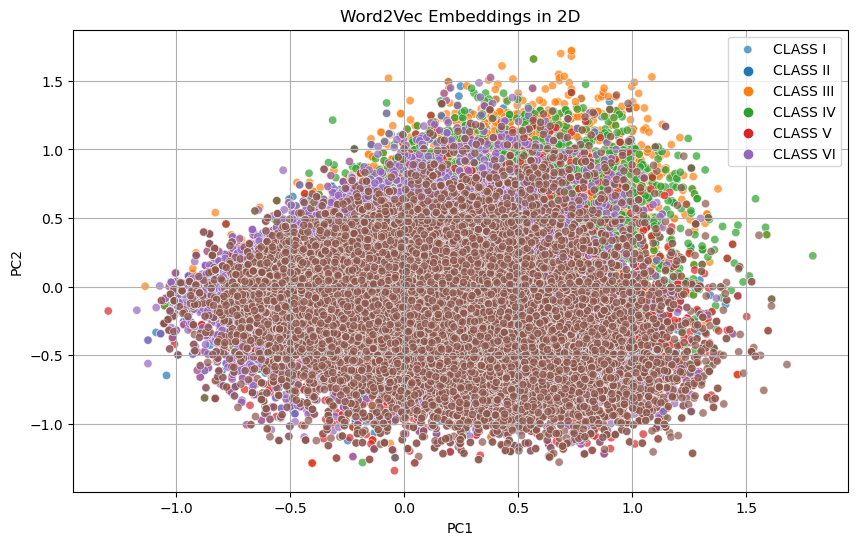

In [35]:
plot_embeddings_in_2D(wv_embeddings, 'Word2Vec')

* For a better understanding, let's see the actual distribution of classes

In [36]:
wv_embeddings['Class'].value_counts()

Class
CLASS V WORDS RELATING TO THE VOLUNTARY POWERS               15276
CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS    13861
CLASS I WORDS EXPRESSING ABSTRACT RELATIONS                  10956
CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES         9762
CLASS II WORDS RELATING TO SPACE                              9181
CLASS III WORDS RELATING TO MATTER                            6912
Name: count, dtype: int64

* We can see a clear problem.
* Word embeddings are not well-separated in the 2D space.
* This shape indicates that **the embeddings lack distinct clusters or meaningful patterns**.
* In simpler words, **our foundations are wick and whatever analysis we built on them, will be insignificant...**

* As we saw, we have many words having multiple classifications.
* In particular this is the percentage of the words that we loose context.

In [37]:
# Count the frequency of each word
word_counts = wv_embeddings['Word'].value_counts()

# Filter words that appear more than once
repeated_words = word_counts[word_counts > 1]

# Get the count of repeated words
num_repeated_words = len(repeated_words)

print(f"Percenage of words that we loose context: {(num_repeated_words/len(word_counts))*100}%")

Percenage of words that we loose context: 25.371382224878342%


* **1/4 of the words, will be noise or irrelevant to our analysis**.
* This suggests that a significant portion of the words may not contribute meaningfully to our analysis and could potentially affect the accuracy or reliability of our results.
* Let's explain it with the previous broad example, 'set' (with `Word2Vec` embeddings).

In [38]:
wv_embeddings[wv_embeddings['Word']=='set']

Word                                              Class  \
448    set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
3621   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
6047   set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
11519  set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
14245  set        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
14704  set                   CLASS II WORDS RELATING TO SPACE   
19982  set                   CLASS II WORDS RELATING TO SPACE   
24067  set                   CLASS II WORDS RELATING TO SPACE   
27746  set                 CLASS III WORDS RELATING TO MATTER   
53277  set     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
88834  set  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                       Division/Section  \
448                SECTION I. EXISTENCE   
3621              SECTION III. QUANTITY   
6047                  SECTION IV. ORDER   
11519               SECTION VII. CHANGE   
14245           SECTION VIII. CAUSATION   
14704       SECTION I. SPACE IN GENERAL   
19982                 SECTION III. FORM   
24067                SECTION IV. MOTION   
27746      SECTION II. INORGANIC MATTER   
53277  DIVISION (I) INDIVIDUAL VOLITION   
88834     SECTION IV. MORAL  AFFECTIONS   

                                               Embedding  
448    [0.029541015625, 0.259765625, 0.193359375, 0.0...  
3621   [0.029541015625, 0.259765625, 0.193359375, 0.0...  
6047   [0.029541015625, 0.259765625, 0.193359375, 0.0...  
11519  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
14245  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
14704  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
19982  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
24067  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
27746  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
53277  [0.029541015625, 0.259765625, 0.193359375, 0.0...  
88834  [0.029541015625, 0.259765625, 0.193359375, 0.0...

* 'set' can mean:
    * *Collection or group of similar items*: CLASS I
    * *Collection of scenery, furniture, or other items used on a stage or for filming*: CLASS II
    * *Arrange or fix something in a specific place or position*: CLASS V
<br/>
      etc.
      
* But it's given the same `Embedding` each time.
* That's what we mean with "we loose context".
* This will surely affect our clustering and classification.
* **But whatever the result, we can learn from it!**

* Let's plot `FastText` ones as well.

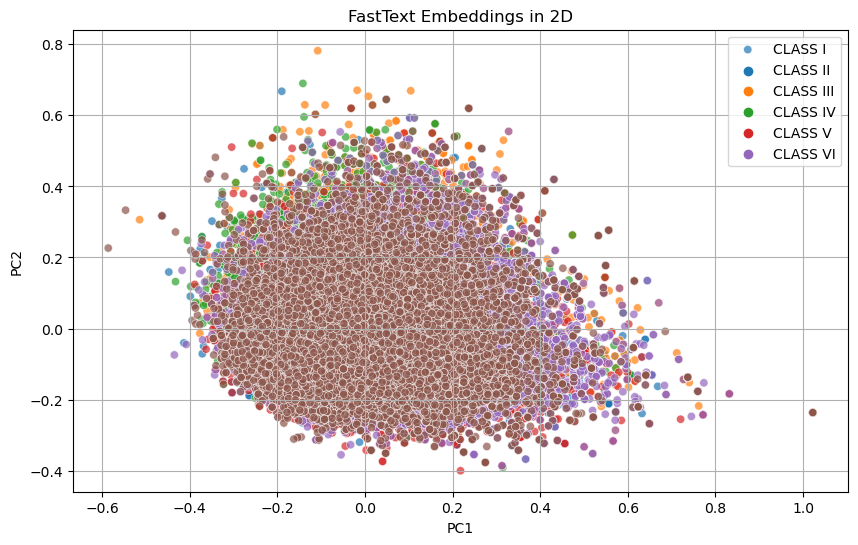

In [39]:
plot_embeddings_in_2D(ft_embeddings, 'FastText')

In [40]:
class_counts = ft_embeddings['Class'].value_counts()
print(class_counts)

Class
CLASS V WORDS RELATING TO THE VOLUNTARY POWERS               15746
CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS    14376
CLASS I WORDS EXPRESSING ABSTRACT RELATIONS                  11361
CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES        10146
CLASS II WORDS RELATING TO SPACE                              9578
CLASS III WORDS RELATING TO MATTER                            7235
Name: count, dtype: int64


* Identical results, as expected.
* `FastText` embeddings are more circular shape because of the additional subword information incorporated during training, which tends to cluster similar words closer together.
* This difference suggests that `FastText` captures little finer semantic relationships between words compared to `Word2Vec`.
* But still, we have the same problem.

* Let's move on to Clustering!
* **Will it arrive at classifications that are comparable to Roget's ?**

## 03. Cluestering

* We will do clustering for:
    * `Class` 
    * and `Division/Section`
* For each, we will test both embeddings models (`Word2Vec`, `FastTesxt`)
* So we will do **4 clusterings in total**.

* We'll utilize `K-Means` clustering with two different values for k: 6 and 22, corresponding to `Class` and `Division/Section`, respectively.
* These numbers are determined based on the unique instances present in each column.
* Here is for `Word2Vec` but it is the same for `FastText` as well.

In [41]:
wv_embeddings.Class.nunique(), wv_embeddings['Division/Section'].nunique()

(6, 22)

* The rationale behind this is to check **whether unsupervised machine learning methods can achieve classification results that closely resemble human (Roget's) judgment**.

* We'll create a function, `kmeans()`, which we'll call twice, for `Class` and `Division/Section`.
* Within this function, we'll extract the embeddings from each model and convert them into a DataFrame, simplifying further processing.
* We'll then apply KMeans clustering to these embeddings, generating predicted cluster labels.
* Depending on the value of k, a new column with cluster predictions will be added.

In [42]:
def kmeans(models, k):
    for model in models:
        # Extract embeddings from the model
        embeddings = model.Embedding
        
        # Convert embeddings to DataFrame with 300 columns
        embeddings_df = pd.DataFrame(embeddings.tolist(), index=embeddings.index)

        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=k, random_state=50)
        
        if k==6:
            model.loc[:, 'Class_KMeans'] = kmeans.fit_predict(embeddings_df)
        else:
            model.loc[:, 'Div/Sec_KMeans'] = kmeans.fit_predict(embeddings_df)
        

### `Class` Clustering

* We will first call it with k=6.

In [43]:
kmeans([wv_embeddings, ft_embeddings], 6)

C:\Users\odysp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\odysp\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\odysp\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(
C:\Users\odysp\AppData\Local\Temp\ipykernel_11896\3839958151.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

* Let's see the new DataFrames.

In [44]:
wv_embeddings.sample(5, random_state=1)

Word                                        Class  \
7243     terrier  CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
849    mutuality  CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
29273  whitecaps           CLASS III WORDS RELATING TO MATTER   
28715        fan           CLASS III WORDS RELATING TO MATTER   
34234    syncope           CLASS III WORDS RELATING TO MATTER   

                   Division/Section  \
7243              SECTION V. NUMBER   
849            SECTION II. RELATION   
29273  SECTION II. INORGANIC MATTER   
28715  SECTION II. INORGANIC MATTER   
34234   SECTION III. ORGANIC MATTER   

                                               Embedding  Class_KMeans  
7243   [-0.01226806640625, 0.29296875, -0.09521484375...             2  
849    [-0.1357421875, -0.435546875, -0.263671875, 0....             1  
29273  [-0.1474609375, -0.06640625, 0.1572265625, -0....             2  
28715  [0.28125, 0.25390625, 0.11279296875, -0.039550...             5  
34234  [-0.07958984375, -0.31640625, 0.02490234375, 0...             4

In [45]:
ft_embeddings.sample(5, random_state=1)

Word                                              Class  \
32654        brimstone                 CLASS III WORDS RELATING TO MATTER   
6970   save and except        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
67872        accession     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
92672          Judaism  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
35546           turbid                 CLASS III WORDS RELATING TO MATTER   

                       Division/Section  \
32654       SECTION III. ORGANIC MATTER   
6970                  SECTION IV. ORDER   
67872  DIVISION (I) INDIVIDUAL VOLITION   
92672   SECTION V. RELIGIOUS AFFECTIONS   
35546       SECTION III. ORGANIC MATTER   

                                               Embedding  Class_KMeans  
32654  [0.02284899912774563, 0.008410300128161907, 0....             1  
6970   [0.024293500930070877, 0.045173998922109604, 0...             0  
67872  [-0.03082199953496456, 0.0036377999931573868, ...             2  
92672  [0.014433000236749649, -0.09557799994945526, 0...             2  
35546  [0.00910049956291914, -0.007850900292396545, 0...             4

* We can clearely see from these samples, that for the same classes, the predicted clusters are different.
* This is the context problem that we pointed out before.
* Here, the word 'fan', is classified in CLASS III, so maybe is referring to *a device for generating airflow*.
* But the given embedding (from `Word2Vec`) may refer to *an enthusiastic admirer*.
* So it is given cluster 5 (as we see two cells below, is equivalent to CLASS V)

* Let's see if the distribution of classes/clusters is similar

In [46]:
wv_embeddings.Class_KMeans.value_counts(), wv_embeddings.Class.value_counts()

(Class_KMeans
 5    20540
 1    12484
 0    11686
 2    11045
 3     6207
 4     3986
 Name: count, dtype: int64,
 Class
 CLASS V WORDS RELATING TO THE VOLUNTARY POWERS               15276
 CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS    13861
 CLASS I WORDS EXPRESSING ABSTRACT RELATIONS                  10956
 CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES         9762
 CLASS II WORDS RELATING TO SPACE                              9181
 CLASS III WORDS RELATING TO MATTER                            6912
 Name: count, dtype: int64)

In [47]:
ft_embeddings.Class_KMeans.value_counts(), ft_embeddings.Class.value_counts()

(Class_KMeans
 2    19795
 3    12543
 5     9858
 0     9074
 4     8658
 1     8514
 Name: count, dtype: int64,
 Class
 CLASS V WORDS RELATING TO THE VOLUNTARY POWERS               15746
 CLASS VI WORDS RELATING TO THE SENTIMENT AND MORAL POWERS    14376
 CLASS I WORDS EXPRESSING ABSTRACT RELATIONS                  11361
 CLASS IV WORDS RELATING TO THE INTELLECTUAL FACULTIES        10146
 CLASS II WORDS RELATING TO SPACE                              9578
 CLASS III WORDS RELATING TO MATTER                            7235
 Name: count, dtype: int64)

* For us, it may seem ok.
* But we can measure the similarity between the two classifications with Adjusted Rand Index (ARI).
* It will compare the agreement of pairs of elements in the same or different clusters.
* A score of 1 indicating perfect agreement and 0 indicating randomness.
* It takes into account both the similarity of the elements grouped by the clusters and the agreement between the clusters themselves.

In [48]:
def ari(df):
    true_labels = df['Class']
    predicted_labels = df['Class_KMeans']

    # Convert true class labels to integer representations
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(true_labels)

    # Now, compute ARI using the true integer labels and the predicted integer labels
    ari = adjusted_rand_score(true_labels_encoded, predicted_labels)
    return ari

print("ARI for W2V:", ari(wv_embeddings))
print("ARI for FT:", ari(ft_embeddings))

ARI for W2V: 0.026181523881235454
ARI for FT: 0.014351111566306198


* These further support our hypotheses.
* With these embeddings, every machine learning method will be similar to someone randomely predicting.
* We made our point, we will continue our journey without complaints.
* We will draw our conclusions at the end of this notebook.

* Let's plot our clusterings.
* We will create a function, `kmeans_plot()`, that we will call four times.
* It visualizes clustering results in 2D using PCA.

In [51]:
def kmeans_plot(df, column, label):
    # Extract embeddings from DataFrame
    embeddings = np.vstack(df['Embedding'].values)
    
    # Apply PCA to reduce dimensionality to 2 dimensions
    pca = PCA(n_components=2)
    embeddings_2D = pca.fit_transform(embeddings)
    
    # Create a new DataFrame for 2D embeddings
    df_2D = pd.DataFrame(embeddings_2D, columns=['PC1', 'PC2'])
    df_2D[column] = df[column] 

    # Plot the clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_2D, x='PC1', y='PC2', hue=column, palette='tab10', alpha=0.7)
    plt.title(f'{label} Clustering')
    plt.legend(title='Cluster', loc='upper left', fontsize='small', bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.show()

* We will call it for both models

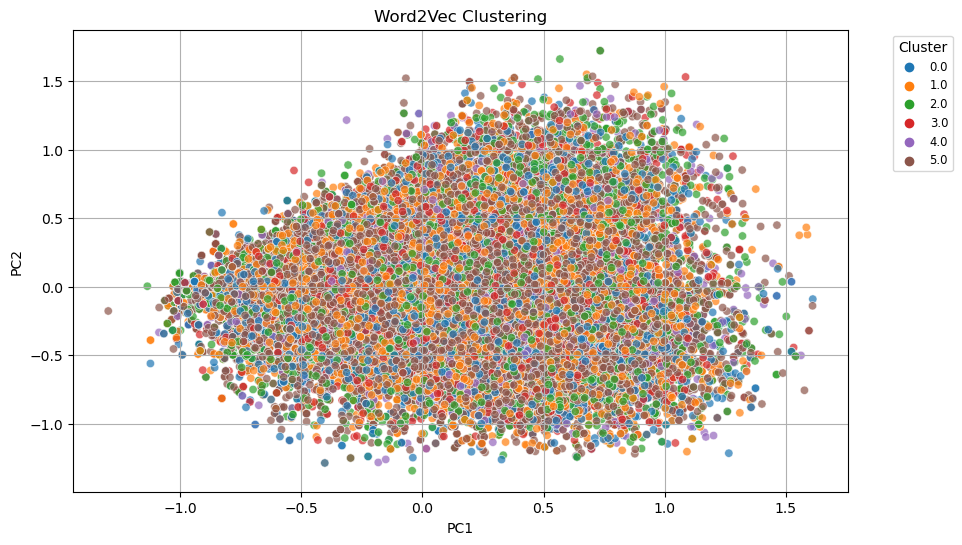

In [52]:
# Assuming your DataFrame is named 'df' and you have two models 'w2v' and 'fasttext'
kmeans_plot(wv_embeddings, 'Class_KMeans', 'Word2Vec')

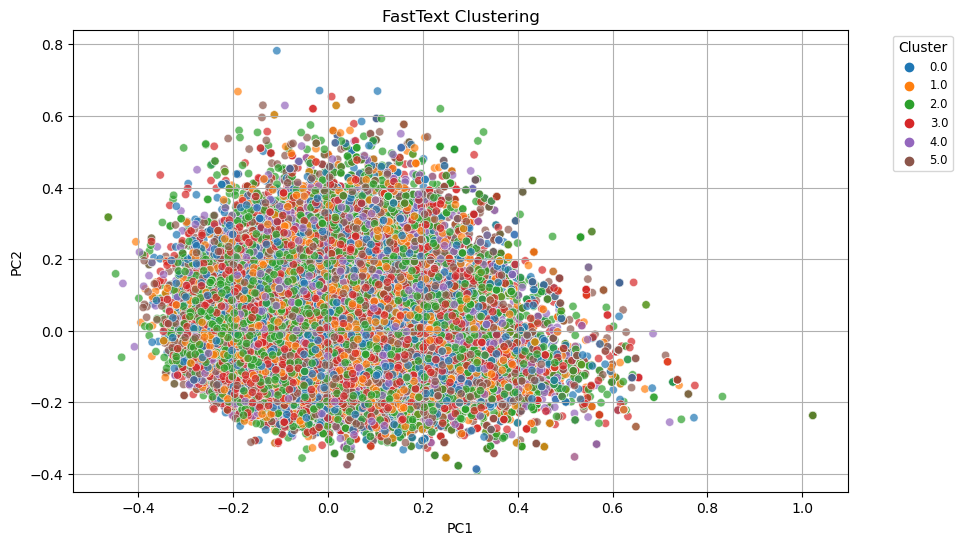

In [53]:
kmeans_plot(ft_embeddings, 'Class_KMeans', 'FastText')

* Comparing Roget's classes with clustering results reveals a big difference in their scatterplots.
* While Roget's exhibited a single color and stacked classes resembling slices.
* The clustering scatterplot presents a chaotic arrangement, each cluster appears intertwined with others, lacking clear boundaries or separations.
* This disparity underscores the **challenge in accurately capturing semantic relationships through clustering**.
* Additionally, poor quality embeddings can amplify this challenge.

* We move on to `Division/Section` level.

### `Division/Section` Clustering

* As we saw before, there are 22 unique values in `Division/Section` columns for both models.
* We can check it once again.

In [54]:
wv_embeddings['Division/Section'].nunique(), ft_embeddings['Division/Section'].nunique()

(22, 22)

* Let's apply K-Means for k=22.

In [55]:
kmeans([wv_embeddings, ft_embeddings], 22)

C:\Users\odysp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\odysp\AppData\Local\Temp\ipykernel_11896\3839958151.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model.loc[:, 'Div/Sec_KMeans'] = kmeans.fit_predict(embeddings_df)
C:\Users\odysp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\odysp\AppData\Lo

* We will take the same steps to assess the clustering.

In [56]:
wv_embeddings.sample(5, random_state=1)

Word                                        Class  \
7243     terrier  CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
849    mutuality  CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
29273  whitecaps           CLASS III WORDS RELATING TO MATTER   
28715        fan           CLASS III WORDS RELATING TO MATTER   
34234    syncope           CLASS III WORDS RELATING TO MATTER   

                   Division/Section  \
7243              SECTION V. NUMBER   
849            SECTION II. RELATION   
29273  SECTION II. INORGANIC MATTER   
28715  SECTION II. INORGANIC MATTER   
34234   SECTION III. ORGANIC MATTER   

                                               Embedding  Class_KMeans  \
7243   [-0.01226806640625, 0.29296875, -0.09521484375...             2   
849    [-0.1357421875, -0.435546875, -0.263671875, 0....             1   
29273  [-0.1474609375, -0.06640625, 0.1572265625, -0....             2   
28715  [0.28125, 0.25390625, 0.11279296875, -0.039550...             5   
34234  [-0.07958984375, -0.31640625, 0.02490234375, 0...             4   

       Div/Sec_KMeans  
7243               18  
849                11  
29273               5  
28715              19  
34234              12

* Here 'whitecaps' and 'fan' are in the same Class-Division/Section classification.
* But were given cluster 5 and 19 respectively.

In [57]:
ft_embeddings.sample(5, random_state=1)

Word                                              Class  \
32654        brimstone                 CLASS III WORDS RELATING TO MATTER   
6970   save and except        CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
67872        accession     CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   
92672          Judaism  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   
35546           turbid                 CLASS III WORDS RELATING TO MATTER   

                       Division/Section  \
32654       SECTION III. ORGANIC MATTER   
6970                  SECTION IV. ORDER   
67872  DIVISION (I) INDIVIDUAL VOLITION   
92672   SECTION V. RELIGIOUS AFFECTIONS   
35546       SECTION III. ORGANIC MATTER   

                                               Embedding  Class_KMeans  \
32654  [0.02284899912774563, 0.008410300128161907, 0....             1   
6970   [0.024293500930070877, 0.045173998922109604, 0...             0   
67872  [-0.03082199953496456, 0.0036377999931573868, ...             2   
92672  [0.014433000236749649, -0.09557799994945526, 0...             2   
35546  [0.00910049956291914, -0.007850900292396545, 0...             4   

       Div/Sec_KMeans  
32654              17  
6970                6  
67872               8  
92672               8  
35546              21

* Or here, 'accession' and 'Judaism' are given the same cluster, although they are not even in the same class
* And the worst part is that in no context, these two words would be classified together...

In [58]:
ft_embeddings[ft_embeddings['Word']=='accession']

Word                                           Class  \
2929   accession     CLASS I WORDS EXPRESSING ABSTRACT RELATIONS   
67872  accession  CLASS V WORDS RELATING TO THE VOLUNTARY POWERS   

                       Division/Section  \
2929              SECTION III. QUANTITY   
67872  DIVISION (I) INDIVIDUAL VOLITION   

                                               Embedding  Class_KMeans  \
2929   [-0.03082199953496456, 0.0036377999931573868, ...             2   
67872  [-0.03082199953496456, 0.0036377999931573868, ...             2   

       Div/Sec_KMeans  
2929                8  
67872               8

In [59]:
ft_embeddings[ft_embeddings['Word']=='Judaism']

Word                                              Class  \
92672  Judaism  CLASS VI WORDS RELATING TO THE SENTIMENT AND M...   

                      Division/Section  \
92672  SECTION V. RELIGIOUS AFFECTIONS   

                                               Embedding  Class_KMeans  \
92672  [0.014433000236749649, -0.09557799994945526, 0...             2   

       Div/Sec_KMeans  
92672               8

* The distribution would consist of numerous rows, making it challenging to derive any meaningful interpretation from it.
* So, let's go straight to ARI.

In [60]:
wv_embeddings['Div/Sec_KMeans'].value_counts(), wv_embeddings['Division/Section'].value_counts()

(Div/Sec_KMeans
 4     7496
 14    7448
 21    4348
 7     4310
 15    3470
 11    3245
 17    3033
 6     2974
 5     2960
 8     2805
 13    2625
 0     2450
 16    2300
 19    2189
 3     2162
 9     2079
 10    1970
 20    1861
 1     1732
 2     1655
 18    1518
 12    1318
 Name: count, dtype: int64,
 Division/Section
 DIVISION (I) INDIVIDUAL VOLITION       15276
 DIVISION (I) FORMATION OF IDEAS         9762
 SECTION II. PERSONAL AFFECTIONS         5581
 SECTION III. ORGANIC MATTER             5147
 SECTION IV. MOTION                      3685
 SECTION IV. MORAL  AFFECTIONS           3549
 SECTION II. DIMENSIONS                  2973
 SECTION III. SYMPATHETIC AFFECTIONS     2283
 SECTION III. QUANTITY                   2256
 SECTION VIII. CAUSATION                 2024
 SECTION VI. TIME                        1818
 SECTION IV. ORDER                       1661
 SECTION II. INORGANIC MATTER            1488
 SECTION V. RELIGIOUS AFFECTIONS         1454
 SECTION III. FORM            

In [61]:
ft_embeddings['Div/Sec_KMeans'].value_counts(), ft_embeddings['Division/Section'].value_counts()

(Div/Sec_KMeans
 8     7534
 0     5547
 20    5251
 1     4911
 12    4129
 4     3724
 16    3626
 18    3591
 5     3432
 9     3126
 15    2895
 7     2797
 2     2598
 17    2471
 21    2319
 13    2166
 10    2081
 6     2010
 19    1667
 14    1158
 11     904
 3      505
 Name: count, dtype: int64,
 Division/Section
 DIVISION (I) INDIVIDUAL VOLITION       15746
 DIVISION (I) FORMATION OF IDEAS        10146
 SECTION II. PERSONAL AFFECTIONS         5723
 SECTION III. ORGANIC MATTER             5373
 SECTION IV. MOTION                      3777
 SECTION IV. MORAL  AFFECTIONS           3681
 SECTION II. DIMENSIONS                  3128
 SECTION III. SYMPATHETIC AFFECTIONS     2343
 SECTION III. QUANTITY                   2315
 SECTION VIII. CAUSATION                 2070
 SECTION VI. TIME                        1913
 SECTION IV. ORDER                       1721
 SECTION V. RELIGIOUS AFFECTIONS         1617
 SECTION II. INORGANIC MATTER            1567
 SECTION III. FORM            

In [62]:
def ari(df):
    true_labels = df['Division/Section']
    predicted_labels = df['Div/Sec_KMeans']

    # Convert true class labels to integer representations
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(true_labels)

    # Now, compute ARI using the true integer labels and the predicted integer labels
    ari = adjusted_rand_score(true_labels_encoded, predicted_labels)
    return ari

print("ARI for W2V:", ari(wv_embeddings))
print("ARI for FT:", ari(ft_embeddings))

ARI for W2V: 0.01803084799697561
ARI for FT: 0.012012588917914582


* Even worst results.
* Logical since with 22 division/section clusters there is increased complexity and data sparsity.
* Let's plot them, even though it would be a bigger chaos.

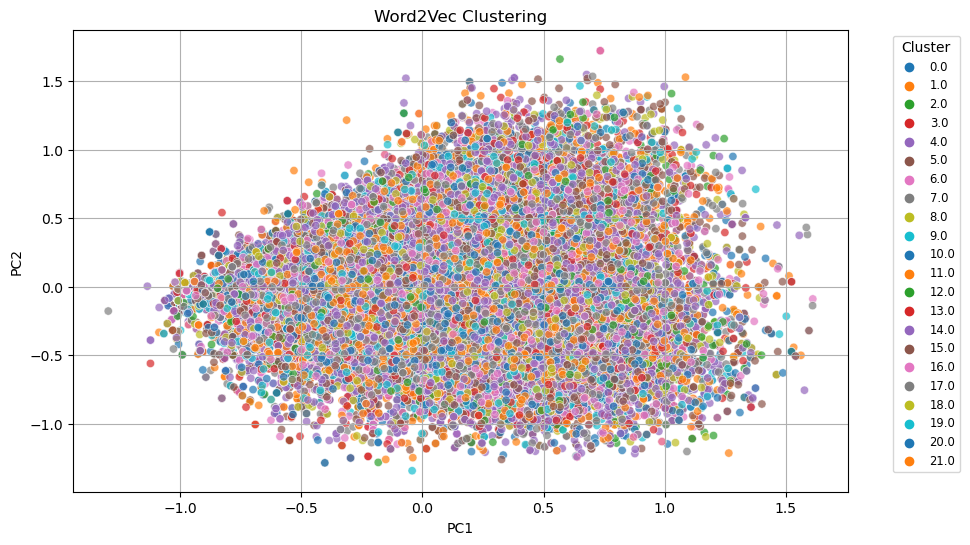

In [63]:
kmeans_plot(wv_embeddings, 'Div/Sec_KMeans', 'Word2Vec')

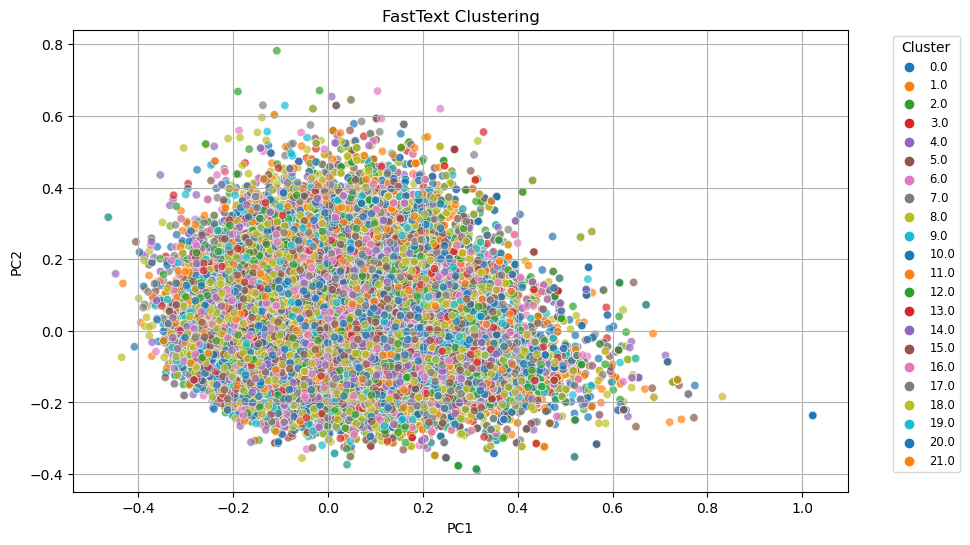

In [64]:
kmeans_plot(ft_embeddings, 'Div/Sec_KMeans', 'FastText')

* We are done with clustering.
* Let's see if supervised Machine Learning method (classification) performs better.
* **Will it predict the class or the division/section accurately ?**

## 04. Class Prediction

* We will search for the best model where the input will be a word, and its target will be its class or division/section.
* As we know, ensemble models perform better at this task.
* They combine multiple individual models which yield better results compared to single models by reducing overfitting, handling noisy data, and capturing diverse patterns in the data.
* By aggregating predictions from multiple models, ensemble methods can provide more robust and reliable predictions.
* We will use `LightGBM`

* But first we need to **prepare the data!**
* We will **extract the embeddings as features** (`X`) **and the class (or Division/Section) labels as the target** (`y`) from the dataframes.
* We will **scale the features** using `StandardScaler` to ensure each feature has a mean of 0 and a standard deviation of 1, crucial for models sensitive to feature scale.
* We wil **encode the class labels** using label encoding, for multi-class classification.

In [65]:
# Extract embeddings as a list from wv_embeddings
embeddings_wv = wv_embeddings['Embedding'].tolist()

# Stack embeddings into a single 2D array
X_wv = np.vstack(embeddings_wv)

# Repeat the same process for ft_embeddings
embeddings_ft = ft_embeddings['Embedding'].tolist()
X_ft = np.vstack(embeddings_ft)

# Scale features
scaler = StandardScaler()

# Scale features for word2vec embeddings
X_wv_scaled = scaler.fit_transform(X_wv)

# Scale features for fasttext embeddings
X_ft_scaled = scaler.fit_transform(X_ft)

# Encode labels
label_encoder = LabelEncoder()

# Encode labels for word2vec embeddings
y_wv_encoded_class = label_encoder.fit_transform(wv_embeddings['Class'])
y_wv_encoded_divsec = label_encoder.fit_transform(wv_embeddings['Division/Section'])

# Encode labels for fasttext embeddings
y_ft_encoded_class = label_encoder.fit_transform(ft_embeddings['Class'])
y_ft_encoded_divsec = label_encoder.fit_transform(ft_embeddings['Division/Section'])

In [66]:
print("Size of word2vec Embeddings:", X_wv.shape)
print("Size of fasttext Embeddings:", X_ft.shape)
print()
print("Size of word2vec scaled embeddings array:", X_wv_scaled.shape)
print("Size of fasttext scaled embeddings array:", X_ft_scaled.shape)
print()
print("Size of word2vec encoded classes:", y_wv_encoded_class.shape)
print("Size of word2vec encoded div/sec:", y_wv_encoded_divsec.shape)
print("Size of fasttext encoded classes:", y_ft_encoded_class.shape)
print("Size of fasttext encoded div/sec:", y_ft_encoded_divsec.shape)

Size of word2vec Embeddings: (65948, 300)
Size of fasttext Embeddings: (68442, 300)

Size of word2vec scaled embeddings array: (65948, 300)
Size of fasttext scaled embeddings array: (68442, 300)

Size of word2vec encoded classes: (65948,)
Size of word2vec encoded div/sec: (65948,)
Size of fasttext encoded classes: (68442,)
Size of fasttext encoded div/sec: (68442,)


* We will split data for training and testing for `Class` prediction.

In [67]:
# Splitting word2vec embeddings data
X_wv_train, X_wv_test, y_wv_train, y_wv_test = train_test_split(X_wv_scaled, y_wv_encoded_class, test_size=0.2, random_state=42)

# Splitting fasttext embeddings data
X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X_ft_scaled, y_ft_encoded_class, test_size=0.2, random_state=42)

In [68]:
print("Size of word2vec Embeddings:", X_wv.shape)
print("Size of word2vec training data:", X_wv_train.shape)
print("Size of word2vec testing data:", X_wv_test.shape)
print("Size of word2vec training labels:", y_wv_train.shape)
print("Size of word2vec testing labels:", y_wv_test.shape)
print()
print("Size of fasttext Embeddings:", X_ft.shape)
print("Size of fasttext training data:", X_ft_train.shape)
print("Size of fasttext testing data:", X_ft_test.shape)
print("Size of fasttext training labels:", y_ft_train.shape)
print("Size of fasttext testing labels:", y_ft_test.shape)

Size of word2vec Embeddings: (65948, 300)
Size of word2vec training data: (52758, 300)
Size of word2vec testing data: (13190, 300)
Size of word2vec training labels: (52758,)
Size of word2vec testing labels: (13190,)

Size of fasttext Embeddings: (68442, 300)
Size of fasttext training data: (54753, 300)
Size of fasttext testing data: (13689, 300)
Size of fasttext training labels: (54753,)
Size of fasttext testing labels: (13689,)


* And now is the time for the model.
* After some testing and much crashing, we concluded on those hyperparameters.
* We decide to not show the process as the results were poor in every case.
* What matters are the conclusions (at the end).

In [69]:
best_params = {
    'n_estimators': 150,
    'max_depth': 3,  #
    'learning_rate': 0.05,
    'min_child_samples': 20, 
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'num_leaves': 31,  
    'force_col_wise': True
}

# Initialize LightGBM classifier with best hyperparameters
lgbm = LGBMClassifier(objective='multiclass', num_class=6, metric='multi_logloss', random_state=1, **best_params)

* Let's fit and predict the `Class`, using `Word2Vec` embeddings

In [70]:
# Train the model
lgbm.fit(X_wv_train, y_wv_train)

# Predict on the test set
y_pred = lgbm.predict(X_wv_test)

# Calculate accuracy
accuracy = accuracy_score(y_wv_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_wv_test, y_pred))

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 52758, number of used features: 300
[LightGBM] [Info] Start training from score -1.792670
[LightGBM] [Info] Start training from score -1.968976
[LightGBM] [Info] Start training from score -2.253180
[LightGBM] [Info] Start training from score -1.917507
[LightGBM] [Info] Start training from score -1.464279
[LightGBM] [Info] Start training from score -1.557780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.42266868840030325

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.37      0.39      2171
           1       0.42      0.35      0.38      1816
           2       0.46      0.32      0.38      1369
           3       0.51      0.31      0.39      2008
           4       0.38      0.53      0.44      3076
           5      

* This is very poor accuracy, consistent with our logic.
* Let's fit and predict with `FastText` embeddings as well.

In [71]:
# Train the model
lgbm.fit(X_ft_train, y_ft_train)

# Predict on the test set
y_pred = lgbm.predict(X_ft_test)

# Calculate accuracy
accuracy = accuracy_score(y_ft_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_ft_test, y_pred))

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 54753, number of used features: 300
[LightGBM] [Info] Start training from score -1.793350
[LightGBM] [Info] Start training from score -1.962002
[LightGBM] [Info] Start training from score -2.236732
[LightGBM] [Info] Start training from score -1.911833
[LightGBM] [Info] Start training from score -1.473988
[LightGBM] [Info] Start training from score -1.563533
Accuracy: 0.4516034772445029

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.40      0.43      2250
           1       0.43      0.42      0.42      1881
           2       0.45      0.38      0.41      1387
           3       0.48      0.37      0.42      2053
           4       0.43      0.51      0.46      3207
           5       0.48      0.55      0.51      2911

    accuracy                           0.45     13689
   macro avg       0.45      0.44      0.44     13689
weight

* Some minor improvement.

* Now, for the last part, we will predict `Division/Section`, given a word.
* We will split the data again, with diferent labels.

In [72]:
# Splitting word2vec embeddings data
X_wv_train, X_wv_test, y_wv_train, y_wv_test = train_test_split(X_wv_scaled, y_wv_encoded_divsec, test_size=0.2, random_state=42)

# Splitting fasttext embeddings data
X_ft_train, X_ft_test, y_ft_train, y_ft_test = train_test_split(X_ft_scaled, y_ft_encoded_divsec, test_size=0.2, random_state=42)

In [73]:
print("Size of word2vec Embeddings:", X_wv.shape)
print("Size of word2vec training data:", X_wv_train.shape)
print("Size of word2vec testing data:", X_wv_test.shape)
print("Size of word2vec training labels:", y_wv_train.shape)
print("Size of word2vec testing labels:", y_wv_test.shape)
print()
print("Size of fasttext Embeddings:", X_ft.shape)
print("Size of fasttext training data:", X_ft_train.shape)
print("Size of fasttext testing data:", X_ft_test.shape)
print("Size of fasttext training labels:", y_ft_train.shape)
print("Size of fasttext testing labels:", y_ft_test.shape)

Size of word2vec Embeddings: (65948, 300)
Size of word2vec training data: (52758, 300)
Size of word2vec testing data: (13190, 300)
Size of word2vec training labels: (52758,)
Size of word2vec testing labels: (13190,)

Size of fasttext Embeddings: (68442, 300)
Size of fasttext training data: (54753, 300)
Size of fasttext testing data: (13689, 300)
Size of fasttext training labels: (54753,)
Size of fasttext testing labels: (13689,)


* We keep the same hyperparameters

In [74]:
best_params = {
    'n_estimators': 150,
    'max_depth': 3,
    'learning_rate': 0.05,
    'min_child_samples': 20, 
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_lambda': 1,
    'reg_alpha': 0,
    'num_leaves': 31, 
    'force_col_wise': True
}

lgbm = LGBMClassifier(objective='multiclass', num_class=6, metric='multi_logloss', random_state=1, **best_params)

* Fit and predict for `Word2Vec`

In [75]:
# Train the model
lgbm.fit(X_wv_train, y_wv_train)

# Predict on the test set
y_pred = lgbm.predict(X_wv_test)

# Calculate accuracy
accuracy = accuracy_score(y_wv_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_wv_test, y_pred))

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 52758, number of used features: 300
[LightGBM] [Info] Start training from score -1.917507
[LightGBM] [Info] Start training from score -1.464279
[LightGBM] [Info] Start training from score -4.182628
[LightGBM] [Info] Start training from score -4.933299
[LightGBM] [Info] Start training from score -5.457370
[LightGBM] [Info] Start training from score -4.064431
[LightGBM] [Info] Start training from score -3.110024
[LightGBM] [Info] Start training from score -3.782561
[LightGBM] [Info] Start training from score -2.467433
[LightGBM] [Info] Start training from score -4.298395
[LightGBM] [Info] Start training from score -3.826823
[LightGBM] [Info] Start training from score -2.550591
[LightGBM] [Info] Start training from score -3.373494
[LightGBM] [Info] Start training from score -3.369630
[LightGBM] [Info] Start training from score -2.916994
[LightGBM] [Info] Start training from score -2.881540
[LightG

* More labels, worst accuracy, as expected.
* Finally, fit and predict for `FastText`

In [76]:
# Train the model
lgbm.fit(X_ft_train, y_ft_train)

# Predict on the test set
y_pred = lgbm.predict(X_ft_test)

# Calculate accuracy
accuracy = accuracy_score(y_ft_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_ft_test, y_pred))

[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 54753, number of used features: 300
[LightGBM] [Info] Start training from score -1.911833
[LightGBM] [Info] Start training from score -1.473988
[LightGBM] [Info] Start training from score -4.203725
[LightGBM] [Info] Start training from score -4.949582
[LightGBM] [Info] Start training from score -5.455266
[LightGBM] [Info] Start training from score -4.097143
[LightGBM] [Info] Start training from score -3.090951
[LightGBM] [Info] Start training from score -3.766970
[LightGBM] [Info] Start training from score -2.480915
[LightGBM] [Info] Start training from score -4.303937
[LightGBM] [Info] Start training from score -3.787721
[LightGBM] [Info] Start training from score -2.533116
[LightGBM] [Info] Start training from score -3.372625
[LightGBM] [Info] Start training from score -3.378499
[LightGBM] [Info] Start training from score -2.928513
[LightGBM] [Info] Start training from score -2.885071
[LightG

##  What did we learn from this analysis of Roget's Thesaurus?

1. That Roget's Thesaurus is... like language philosophy masked as a book/(anti)dictionary.
2. The complexity of language. So many meanings and nuances for each word.
3. The quality of word embeddings is everything. And to get the best embeddings you need to add context.
4. Having a deep understanding of the subject matter and the data itself is essential for drawing meaningful conclusions.
5. The power of these models, if we structure our data correctly.

<img src="./images/roget.jpg" alt="roget" width="350"/>

*P.S. I think Roget’s Thesaurus will be useful to me not just only for gaining key insights about embeddings but also for articulating thoughts and concepts when I’m grappling with ideas I don’t have words for yet.